In [1]:
import h5py
import numpy as np
import pandas as pd
import phenograph
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn import manifold
%matplotlib inline
from sklearn.manifold import TSNE
import scanpy.api as sc
from collections import Counter
from sklearn.metrics import mutual_info_score
from sklearn.metrics import jaccard_similarity_score
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [3]:
@jit
def subsample(matrix, proportion=0.8):
    # proportion percentages are going to be kept the same
    n_samples_without_replacement = int(matrix.shape[0]*proportion)
    n_samples_with_replacement = matrix.shape[0]-n_samples_without_replacement
    subsampled = matrix.sample(n=n_samples_without_replacement, replace=False)
    subsampled2 = subsampled.sample(n=n_samples_with_replacement, replace=False)
    subsampled_final = pd.concat((subsampled, subsampled2), axis=0)
    np.random.shuffle(subsampled_final)
    return subsampled_final

def preprocess_zheng17(matrix):
    mask1 = (matrix.sum(axis=0) > 3)
    filtered_matrix = matrix [:,mask1]
    adata = sc.AnnData(filtered_matrix)
    sc.pp.normalize_per_cell(adata)
    filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
    mask2 = filter_result.gene_subset
    adata = adata[:, mask2]
    sc.pp.normalize_per_cell(adata)
    matrix = adata.X
    return matrix

def run_phenograph(matrix):
    current = time.time()
    communities, graph, Q = phenograph.cluster(matrix, n_jobs=8, k=100, primary_metric='euclidean')
    end = time.time()
    diff = end - current
    print(diff)
    return communities

@jit
def compute_jaccard(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1) | set(list2))
    return intersection / union

In [4]:
input_file = '/cluster/home/mtuncel/sc-pipe/intermediate_files/coding_region_only_melanomaS2.h5'

In [5]:
h5f = h5py.File(input_file, 'r')

In [6]:
h5f = h5py.File(input_file, 'r')
matrix = h5f['matrix'][:]
barcodes = h5f['cell_attrs']['cell_names'].value
#cell_groups = h5f['cell_attrs']['cell_groups'].value

matrix = np.log1p(matrix)

In [7]:
h5f.close()

In [8]:
%%capture
preprocessed = preprocess_zheng17(matrix)
communities = run_phenograph(preprocessed)

In [9]:
original_df = pd.DataFrame(matrix)

In [10]:
original_df['labels'] = communities
original_df['original_index'] = original_df.index

## Assessment of cluster robustness

The evaluation procedure is described in the following publication: “Cluster-wise assessment of cluster stability,” Research Report 271, Dept. of Statistical Science, University College London, December 2006)
<br>

Given a clustering on a data set generated by a clustering method, the following principle is applied:
* Interpret the Jaccard coefficient (Jaccard, 1901) as a measure of similarity between two subsets of a set based on set membership.
* Resample new data sets from the original one (using various strategies) and apply the clustering method to them. 
* For every given cluster in the original clustering find the most similar cluster in the new clustering and record the
similarity value.
* Assess the cluster stability of every single cluster by the mean similarity taken over the resampled data sets.
###### Notes:
* Resampling is assessed by 100 bootstrap samples containing 80% of the unique cells.
* The clusters bigger than 10% of the number of all cells are selected for the evaluation. 

### Original sizes of clusters

In [11]:
dict(Counter(communities))

{0: 892, 1: 282, 2: 280, 3: 222, 4: 171, 5: 169, 6: 106, 7: 94}

In [12]:
significant_clusters = []
size_criteria = len(communities)/10
for k,v in dict(Counter(communities)).items():
    if v>size_criteria:
        significant_clusters.append(k)
    else:
        pass

### The clusters that contain > 10% of all cells

In [13]:
significant_clusters

[0, 2, 1, 3]

In [14]:
max_jaccard_vals_dist = []
for j in tqdm(range(1,100)):
    ss = subsample(original_df)
    ss_index = ss.index.values
    ss = ss.drop(['labels','original_index'], axis=1)
    preprocessed_ss = preprocess_zheng17(ss.values)
    ss_communities = run_phenograph(preprocessed_ss)
    
    max_jaccard_vals = []
    for i in significant_clusters:
        original_clust_vals = original_df[communities==i].index.values
        ss_jaccard_vals = []
        for k,v in dict(Counter(ss_communities)).items():
            ss_clust_vals = ss_index[ss_communities == k]
            jaccard = compute_jaccard(original_clust_vals, ss_clust_vals)
            #print('jaccard value for' + str(k) + 'is equal to: ' + str(jaccard))
            ss_jaccard_vals.append(jaccard)
        max_jaccard_vals.append(max(ss_jaccard_vals))
    max_jaccard_vals_dist.append(max_jaccard_vals)

  0%|          | 0/99 [00:00<?, ?it/s]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9577445983886719 seconds
Jaccard graph constructed in 1.1300320625305176 seconds
Wrote graph to binary file in 0.42053771018981934 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795577
Louvain completed 21 runs in 1.4192678928375244 seconds
PhenoGraph complete in 4.0252978801727295 seconds
4.075337648391724


  1%|          | 1/99 [00:08<13:25,  8.22s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3682069778442383 seconds
Jaccard graph constructed in 1.0655848979949951 seconds
Wrote graph to binary file in 0.4268367290496826 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796744
After 6 runs, maximum modularity is Q = 0.797759
Louvain completed 26 runs in 1.744666576385498 seconds
PhenoGraph complete in 4.704603672027588 seconds


  2%|▏         | 2/99 [00:15<12:29,  7.72s/it]

4.745293617248535
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3774266242980957 seconds
Jaccard graph constructed in 1.1018073558807373 seconds
Wrote graph to binary file in 0.4186367988586426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.814764
Louvain completed 21 runs in 1.3090050220489502 seconds
PhenoGraph complete in 4.305963039398193 seconds
4.347801446914673


  3%|▎         | 3/99 [00:22<11:53,  7.43s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.359654426574707 seconds
Jaccard graph constructed in 1.1403279304504395 seconds
Wrote graph to binary file in 0.4291853904724121 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.810075
After 4 runs, maximum modularity is Q = 0.812275
Louvain completed 24 runs in 1.5709617137908936 seconds
PhenoGraph complete in 4.610469579696655 seconds


  4%|▍         | 4/99 [00:29<11:40,  7.38s/it]

4.655852794647217
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1847059726715088 seconds
Jaccard graph constructed in 1.1050055027008057 seconds
Wrote graph to binary file in 0.4563610553741455 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789477
After 2 runs, maximum modularity is Q = 0.794761
After 3 runs, maximum modularity is Q = 0.797147
Louvain completed 23 runs in 1.6460387706756592 seconds
PhenoGraph complete in 4.49229097366333 seconds


  5%|▌         | 5/99 [00:36<11:26,  7.30s/it]

4.537329912185669
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1585872173309326 seconds
Jaccard graph constructed in 1.0601449012756348 seconds
Wrote graph to binary file in 0.34528684616088867 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794723
After 3 runs, maximum modularity is Q = 0.796137
Louvain completed 23 runs in 1.6286334991455078 seconds
PhenoGraph complete in 4.294857740402222 seconds


  6%|▌         | 6/99 [00:43<11:11,  7.22s/it]

4.338042259216309
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.252225637435913 seconds
Jaccard graph constructed in 1.2430953979492188 seconds
Wrote graph to binary file in 0.33844757080078125 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.806605
After 14 runs, maximum modularity is Q = 0.807983
Louvain completed 34 runs in 2.1854140758514404 seconds
PhenoGraph complete in 5.11383843421936 seconds


  7%|▋         | 7/99 [00:50<11:09,  7.28s/it]

5.15778112411499
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1607589721679688 seconds
Jaccard graph constructed in 1.0955495834350586 seconds
Wrote graph to binary file in 0.49315333366394043 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79515
After 2 runs, maximum modularity is Q = 0.80356
Louvain completed 22 runs in 1.5850660800933838 seconds
PhenoGraph complete in 4.431582927703857 seconds
4.472945213317871


  8%|▊         | 8/99 [00:57<10:58,  7.24s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2572450637817383 seconds
Jaccard graph constructed in 1.1643946170806885 seconds
Wrote graph to binary file in 0.4628276824951172 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804191
Louvain completed 21 runs in 1.35689115524292 seconds
PhenoGraph complete in 4.342218399047852 seconds


  9%|▉         | 9/99 [01:04<10:47,  7.19s/it]

4.386427640914917
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.956709623336792 seconds
Jaccard graph constructed in 1.1003637313842773 seconds
Wrote graph to binary file in 0.4832422733306885 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797393
Louvain completed 21 runs in 1.3808393478393555 seconds
PhenoGraph complete in 4.02570915222168 seconds


 10%|█         | 10/99 [01:11<10:34,  7.13s/it]

4.070281267166138
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5578296184539795 seconds
Jaccard graph constructed in 1.3320448398590088 seconds
Wrote graph to binary file in 0.4285132884979248 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792664
Louvain completed 21 runs in 1.490967035293579 seconds
PhenoGraph complete in 4.911110877990723 seconds


 11%|█         | 11/99 [01:18<10:30,  7.16s/it]

4.949294090270996
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3562839031219482 seconds
Jaccard graph constructed in 1.058856725692749 seconds
Wrote graph to binary file in 0.49414920806884766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801243
Louvain completed 21 runs in 1.3518531322479248 seconds
PhenoGraph complete in 4.370672225952148 seconds


 12%|█▏        | 12/99 [01:25<10:20,  7.14s/it]

4.411421298980713
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8769373893737793 seconds
Jaccard graph constructed in 1.0817601680755615 seconds
Wrote graph to binary file in 0.4716980457305908 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795854
After 5 runs, maximum modularity is Q = 0.799419
Louvain completed 25 runs in 1.6386315822601318 seconds
PhenoGraph complete in 4.199163436889648 seconds


 13%|█▎        | 13/99 [01:32<10:10,  7.10s/it]

4.243617057800293
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8552253246307373 seconds
Jaccard graph constructed in 1.2051098346710205 seconds
Wrote graph to binary file in 0.47771358489990234 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804655
After 2 runs, maximum modularity is Q = 0.8066
Louvain completed 22 runs in 1.6224007606506348 seconds
PhenoGraph complete in 4.2649431228637695 seconds


 14%|█▍        | 14/99 [01:39<10:01,  7.07s/it]

4.305623531341553
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3545186519622803 seconds
Jaccard graph constructed in 1.1155550479888916 seconds
Wrote graph to binary file in 0.49051594734191895 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790147
After 4 runs, maximum modularity is Q = 0.792481
Louvain completed 24 runs in 1.652109146118164 seconds
PhenoGraph complete in 4.722389459609985 seconds


 15%|█▌        | 15/99 [01:46<09:54,  7.08s/it]

4.7667155265808105
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1550145149230957 seconds
Jaccard graph constructed in 1.1382713317871094 seconds
Wrote graph to binary file in 0.36457037925720215 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790414
After 2 runs, maximum modularity is Q = 0.792707
After 6 runs, maximum modularity is Q = 0.793794
Louvain completed 26 runs in 1.9160041809082031 seconds
PhenoGraph complete in 4.670425891876221 seconds


 16%|█▌        | 16/99 [01:53<09:48,  7.09s/it]

4.727193593978882
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1536450386047363 seconds
Jaccard graph constructed in 1.116877555847168 seconds
Wrote graph to binary file in 0.47974562644958496 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.811414
After 5 runs, maximum modularity is Q = 0.812617
Louvain completed 25 runs in 1.7569279670715332 seconds
PhenoGraph complete in 4.62733268737793 seconds


 17%|█▋        | 17/99 [02:00<09:41,  7.09s/it]

4.670916318893433
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3557603359222412 seconds
Jaccard graph constructed in 1.1143240928649902 seconds
Wrote graph to binary file in 0.5297331809997559 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794244
After 4 runs, maximum modularity is Q = 0.795261
Louvain completed 24 runs in 1.5856115818023682 seconds
PhenoGraph complete in 4.688129425048828 seconds


 18%|█▊        | 18/99 [02:07<09:35,  7.10s/it]

4.7328550815582275
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.870328426361084 seconds
Jaccard graph constructed in 1.108856201171875 seconds
Wrote graph to binary file in 0.5011234283447266 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803558
Louvain completed 21 runs in 1.4887373447418213 seconds
PhenoGraph complete in 4.101238489151001 seconds


 19%|█▉        | 19/99 [02:14<09:26,  7.08s/it]

4.147666692733765
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2513279914855957 seconds
Jaccard graph constructed in 1.1960339546203613 seconds
Wrote graph to binary file in 0.37186551094055176 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.808152
Louvain completed 21 runs in 1.4136326313018799 seconds
PhenoGraph complete in 4.330359220504761 seconds


 20%|██        | 20/99 [02:21<09:18,  7.07s/it]

4.371003866195679
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9529533386230469 seconds
Jaccard graph constructed in 1.08005952835083 seconds
Wrote graph to binary file in 0.5448317527770996 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795368
After 4 runs, maximum modularity is Q = 0.796949
After 22 runs, maximum modularity is Q = 0.798062
Louvain completed 42 runs in 2.8741092681884766 seconds
PhenoGraph complete in 5.556420564651489 seconds


 21%|██        | 21/99 [02:29<09:14,  7.11s/it]

5.604201793670654
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9633188247680664 seconds
Jaccard graph constructed in 1.0288059711456299 seconds
Wrote graph to binary file in 0.5195825099945068 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799974
After 3 runs, maximum modularity is Q = 0.801779
After 5 runs, maximum modularity is Q = 0.803021
Louvain completed 25 runs in 1.8268218040466309 seconds
PhenoGraph complete in 4.437646865844727 seconds
4.499152421951294


 22%|██▏       | 22/99 [02:36<09:07,  7.11s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9570939540863037 seconds
Jaccard graph constructed in 1.2276508808135986 seconds
Wrote graph to binary file in 0.4708995819091797 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799703
Louvain completed 21 runs in 1.4338843822479248 seconds
PhenoGraph complete in 4.1910154819488525 seconds


 23%|██▎       | 23/99 [02:43<08:59,  7.09s/it]

4.239872217178345
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3617424964904785 seconds
Jaccard graph constructed in 1.0886943340301514 seconds
Wrote graph to binary file in 0.4583323001861572 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.8071
Louvain completed 21 runs in 1.2703189849853516 seconds
PhenoGraph complete in 4.30812406539917 seconds
4.35646653175354


 24%|██▍       | 24/99 [02:50<08:51,  7.09s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4779605865478516 seconds
Jaccard graph constructed in 1.170668601989746 seconds
Wrote graph to binary file in 0.6182441711425781 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785731
After 2 runs, maximum modularity is Q = 0.787554
After 3 runs, maximum modularity is Q = 0.789934
Louvain completed 23 runs in 1.7268762588500977 seconds
PhenoGraph complete in 5.1098105907440186 seconds
5.150177478790283


 25%|██▌       | 25/99 [02:58<08:47,  7.13s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.362278938293457 seconds
Jaccard graph constructed in 1.2237896919250488 seconds
Wrote graph to binary file in 0.46489882469177246 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.800767
After 2 runs, maximum modularity is Q = 0.80198
Louvain completed 22 runs in 1.593374252319336 seconds
PhenoGraph complete in 4.747162818908691 seconds
4.788288831710815


 26%|██▋       | 26/99 [03:05<08:41,  7.14s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9660470485687256 seconds
Jaccard graph constructed in 1.1589009761810303 seconds
Wrote graph to binary file in 0.48885393142700195 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797282
After 7 runs, maximum modularity is Q = 0.798785
Louvain completed 27 runs in 2.09281063079834 seconds
PhenoGraph complete in 4.833311557769775 seconds
4.877972602844238


 27%|██▋       | 27/99 [03:13<08:35,  7.15s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.456362247467041 seconds
Jaccard graph constructed in 1.1587433815002441 seconds
Wrote graph to binary file in 0.4278738498687744 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801966
Louvain completed 21 runs in 1.3535957336425781 seconds
PhenoGraph complete in 4.520318031311035 seconds
4.579528570175171


 28%|██▊       | 28/99 [03:20<08:27,  7.15s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2613928318023682 seconds
Jaccard graph constructed in 1.4131536483764648 seconds
Wrote graph to binary file in 0.3470308780670166 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792025
After 7 runs, maximum modularity is Q = 0.793202
Louvain completed 27 runs in 1.8345866203308105 seconds
PhenoGraph complete in 4.951289892196655 seconds


 29%|██▉       | 29/99 [03:27<08:21,  7.17s/it]

4.998832702636719
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4756200313568115 seconds
Jaccard graph constructed in 1.2284166812896729 seconds
Wrote graph to binary file in 0.4462850093841553 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79203
Louvain completed 21 runs in 1.5439035892486572 seconds
PhenoGraph complete in 4.791243553161621 seconds
4.835441589355469


 30%|███       | 30/99 [03:35<08:15,  7.18s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3629529476165771 seconds
Jaccard graph constructed in 1.172060251235962 seconds
Wrote graph to binary file in 0.46711134910583496 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79449
Louvain completed 21 runs in 1.3915090560913086 seconds
PhenoGraph complete in 4.525712013244629 seconds


 31%|███▏      | 31/99 [03:42<08:07,  7.18s/it]

4.582864284515381
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3557844161987305 seconds
Jaccard graph constructed in 1.2107772827148438 seconds
Wrote graph to binary file in 0.4888150691986084 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796981
After 3 runs, maximum modularity is Q = 0.799351
Louvain completed 23 runs in 1.7020111083984375 seconds
PhenoGraph complete in 4.858680009841919 seconds


 32%|███▏      | 32/99 [03:49<08:01,  7.18s/it]

4.9049131870269775
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2602455615997314 seconds
Jaccard graph constructed in 1.2028377056121826 seconds
Wrote graph to binary file in 0.37951064109802246 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809784
After 19 runs, maximum modularity is Q = 0.810801
Louvain completed 39 runs in 2.5961496829986572 seconds
PhenoGraph complete in 5.543459177017212 seconds


 33%|███▎      | 33/99 [03:58<07:56,  7.22s/it]

5.7602362632751465
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3595678806304932 seconds
Jaccard graph constructed in 1.196946382522583 seconds
Wrote graph to binary file in 0.44728684425354004 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792099
After 3 runs, maximum modularity is Q = 0.79382
Louvain completed 23 runs in 1.8025918006896973 seconds
PhenoGraph complete in 4.904568195343018 seconds


 34%|███▍      | 34/99 [04:05<07:49,  7.23s/it]

4.949826002120972
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3740196228027344 seconds
Jaccard graph constructed in 1.1776103973388672 seconds
Wrote graph to binary file in 0.4621288776397705 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792895
After 2 runs, maximum modularity is Q = 0.793925
After 4 runs, maximum modularity is Q = 0.794931
Louvain completed 24 runs in 2.0748631954193115 seconds
PhenoGraph complete in 5.23350977897644 seconds


 35%|███▌      | 35/99 [04:13<07:43,  7.25s/it]

5.279780626296997
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3707857131958008 seconds
Jaccard graph constructed in 1.3218562602996826 seconds
Wrote graph to binary file in 0.47601914405822754 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.800972
After 2 runs, maximum modularity is Q = 0.802248
Louvain completed 22 runs in 1.6941320896148682 seconds
PhenoGraph complete in 4.966059923171997 seconds
5.015181064605713


 36%|███▋      | 36/99 [04:21<07:37,  7.27s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4759917259216309 seconds
Jaccard graph constructed in 1.2055425643920898 seconds
Wrote graph to binary file in 0.5147860050201416 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807087
Louvain completed 21 runs in 1.5029053688049316 seconds
PhenoGraph complete in 4.802160739898682 seconds


 37%|███▋      | 37/99 [04:29<07:31,  7.28s/it]

4.851278305053711
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4588899612426758 seconds
Jaccard graph constructed in 1.2286412715911865 seconds
Wrote graph to binary file in 0.6045138835906982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80565
After 4 runs, maximum modularity is Q = 0.807128
Louvain completed 24 runs in 1.7433950901031494 seconds
PhenoGraph complete in 5.167481422424316 seconds
5.215270280838013


 38%|███▊      | 38/99 [04:36<07:24,  7.29s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9531044960021973 seconds
Jaccard graph constructed in 1.1364150047302246 seconds
Wrote graph to binary file in 0.44863367080688477 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792503
After 18 runs, maximum modularity is Q = 0.794477
Louvain completed 38 runs in 2.552704334259033 seconds
PhenoGraph complete in 5.190840005874634 seconds


 39%|███▉      | 39/99 [04:44<07:18,  7.30s/it]

5.23708701133728
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3603863716125488 seconds
Jaccard graph constructed in 1.1278843879699707 seconds
Wrote graph to binary file in 0.5368974208831787 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792032
After 6 runs, maximum modularity is Q = 0.7935
Louvain completed 26 runs in 1.745967149734497 seconds
PhenoGraph complete in 4.875571012496948 seconds
4.931361198425293


 40%|████      | 40/99 [04:52<07:11,  7.31s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.357604742050171 seconds
Jaccard graph constructed in 1.1999151706695557 seconds
Wrote graph to binary file in 0.44246840476989746 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80771
Louvain completed 21 runs in 1.4499523639678955 seconds
PhenoGraph complete in 4.545199155807495 seconds


 41%|████▏     | 41/99 [04:59<07:03,  7.30s/it]

4.585787057876587
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4591038227081299 seconds
Jaccard graph constructed in 1.2583632469177246 seconds
Wrote graph to binary file in 0.48471617698669434 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802082
After 2 runs, maximum modularity is Q = 0.804226
Louvain completed 22 runs in 1.673452615737915 seconds
PhenoGraph complete in 4.996819019317627 seconds


 42%|████▏     | 42/99 [05:07<06:56,  7.31s/it]

5.040994167327881
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3558390140533447 seconds
Jaccard graph constructed in 1.1612577438354492 seconds
Wrote graph to binary file in 0.4349541664123535 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809777
After 6 runs, maximum modularity is Q = 0.811142
Louvain completed 26 runs in 1.7768959999084473 seconds
PhenoGraph complete in 4.837102174758911 seconds


 43%|████▎     | 43/99 [05:14<06:49,  7.31s/it]

4.8795716762542725
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0638782978057861 seconds
Jaccard graph constructed in 1.2386765480041504 seconds
Wrote graph to binary file in 0.445096492767334 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804704
After 4 runs, maximum modularity is Q = 0.805922
Louvain completed 24 runs in 1.675323724746704 seconds
PhenoGraph complete in 4.519642114639282 seconds


 44%|████▍     | 44/99 [05:21<06:41,  7.31s/it]

4.5644237995147705
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0537772178649902 seconds
Jaccard graph constructed in 1.0890371799468994 seconds
Wrote graph to binary file in 0.5575878620147705 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801133
Louvain completed 21 runs in 1.2986915111541748 seconds
PhenoGraph complete in 4.0948474407196045 seconds


 45%|████▌     | 45/99 [05:28<06:33,  7.29s/it]

4.140197277069092
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2598214149475098 seconds
Jaccard graph constructed in 1.265744924545288 seconds
Wrote graph to binary file in 0.47706031799316406 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794351
After 4 runs, maximum modularity is Q = 0.796324
After 17 runs, maximum modularity is Q = 0.797324
Louvain completed 37 runs in 2.4886248111724854 seconds
PhenoGraph complete in 5.593265771865845 seconds


 46%|████▋     | 46/99 [05:36<06:27,  7.31s/it]

5.650058746337891
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2566101551055908 seconds
Jaccard graph constructed in 1.284989833831787 seconds
Wrote graph to binary file in 0.34898948669433594 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797845
After 2 runs, maximum modularity is Q = 0.799524
After 3 runs, maximum modularity is Q = 0.800906
Louvain completed 23 runs in 1.9231963157653809 seconds
PhenoGraph complete in 4.912721872329712 seconds


 47%|████▋     | 47/99 [05:43<06:20,  7.32s/it]

4.957190752029419
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0679149627685547 seconds
Jaccard graph constructed in 1.1764862537384033 seconds
Wrote graph to binary file in 0.4561026096343994 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799131
After 5 runs, maximum modularity is Q = 0.800346
Louvain completed 25 runs in 1.8307733535766602 seconds
PhenoGraph complete in 4.642035961151123 seconds


 48%|████▊     | 48/99 [05:51<06:13,  7.32s/it]

4.687557697296143
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9583871364593506 seconds
Jaccard graph constructed in 1.0885472297668457 seconds
Wrote graph to binary file in 0.4401240348815918 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789522
After 2 runs, maximum modularity is Q = 0.793238
After 4 runs, maximum modularity is Q = 0.795304
Louvain completed 24 runs in 1.7494571208953857 seconds
PhenoGraph complete in 4.332285404205322 seconds


 49%|████▉     | 49/99 [05:57<06:05,  7.31s/it]

4.372427940368652
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8785111904144287 seconds
Jaccard graph constructed in 1.1853001117706299 seconds
Wrote graph to binary file in 0.44913506507873535 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794907
After 5 runs, maximum modularity is Q = 0.795989
Louvain completed 25 runs in 1.8324694633483887 seconds
PhenoGraph complete in 4.47117280960083 seconds


 51%|█████     | 50/99 [06:05<05:57,  7.30s/it]

4.515009164810181
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.353008508682251 seconds
Jaccard graph constructed in 1.0714406967163086 seconds
Wrote graph to binary file in 0.5395801067352295 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807643
After 13 runs, maximum modularity is Q = 0.808749
Louvain completed 33 runs in 2.0710196495056152 seconds
PhenoGraph complete in 5.129728317260742 seconds


 52%|█████▏    | 51/99 [06:12<05:50,  7.31s/it]

5.184214353561401
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3605537414550781 seconds
Jaccard graph constructed in 1.1005542278289795 seconds
Wrote graph to binary file in 0.3600180149078369 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793397
After 2 runs, maximum modularity is Q = 0.795569
After 16 runs, maximum modularity is Q = 0.796643
Louvain completed 36 runs in 2.4463586807250977 seconds
PhenoGraph complete in 5.36428689956665 seconds


 53%|█████▎    | 52/99 [06:20<05:44,  7.32s/it]

5.408202886581421
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0589888095855713 seconds
Jaccard graph constructed in 1.2139496803283691 seconds
Wrote graph to binary file in 0.4547147750854492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799644
Louvain completed 21 runs in 1.3581135272979736 seconds
PhenoGraph complete in 4.184588670730591 seconds


 54%|█████▎    | 53/99 [06:27<05:36,  7.31s/it]

4.224593162536621
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4674062728881836 seconds
Jaccard graph constructed in 1.1569643020629883 seconds
Wrote graph to binary file in 0.47634053230285645 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798884
After 2 runs, maximum modularity is Q = 0.800624
After 11 runs, maximum modularity is Q = 0.80183
Louvain completed 31 runs in 2.1950464248657227 seconds
PhenoGraph complete in 5.402020215988159 seconds


 55%|█████▍    | 54/99 [06:35<05:29,  7.32s/it]

5.446655988693237
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9604926109313965 seconds
Jaccard graph constructed in 1.1234264373779297 seconds
Wrote graph to binary file in 0.548959493637085 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797119
After 2 runs, maximum modularity is Q = 0.79875
Louvain completed 22 runs in 1.4024157524108887 seconds
PhenoGraph complete in 4.141988754272461 seconds


 56%|█████▌    | 55/99 [06:42<05:21,  7.31s/it]

4.18684720993042
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8559174537658691 seconds
Jaccard graph constructed in 1.1257846355438232 seconds
Wrote graph to binary file in 0.4575321674346924 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799358
Louvain completed 21 runs in 1.4786548614501953 seconds
PhenoGraph complete in 4.021296977996826 seconds
4.067203044891357


 57%|█████▋    | 56/99 [06:48<05:13,  7.30s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4601237773895264 seconds
Jaccard graph constructed in 1.0886707305908203 seconds
Wrote graph to binary file in 0.3727271556854248 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802603
Louvain completed 21 runs in 1.3963658809661865 seconds
PhenoGraph complete in 4.416031122207642 seconds


 58%|█████▊    | 57/99 [06:55<05:06,  7.29s/it]

4.455523490905762
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0592217445373535 seconds
Jaccard graph constructed in 1.0912084579467773 seconds
Wrote graph to binary file in 0.4600207805633545 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803524
Louvain completed 21 runs in 1.4351425170898438 seconds
PhenoGraph complete in 4.189643859863281 seconds


 59%|█████▊    | 58/99 [07:02<04:58,  7.28s/it]

4.244777679443359
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0565354824066162 seconds
Jaccard graph constructed in 1.1777031421661377 seconds
Wrote graph to binary file in 0.45184326171875 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792991
After 2 runs, maximum modularity is Q = 0.794442
After 15 runs, maximum modularity is Q = 0.795458
Louvain completed 35 runs in 2.3642451763153076 seconds
PhenoGraph complete in 5.1546311378479 seconds


 60%|█████▉    | 59/99 [07:10<04:51,  7.29s/it]

5.196566104888916
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3692340850830078 seconds
Jaccard graph constructed in 1.3902595043182373 seconds
Wrote graph to binary file in 0.6120870113372803 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.800008
Louvain completed 21 runs in 1.8171217441558838 seconds
PhenoGraph complete in 5.346382141113281 seconds


 61%|██████    | 60/99 [07:18<04:45,  7.31s/it]

5.724822998046875
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0645065307617188 seconds
Jaccard graph constructed in 1.2734768390655518 seconds
Wrote graph to binary file in 0.3909940719604492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807231
After 5 runs, maximum modularity is Q = 0.808899
Louvain completed 25 runs in 1.8276004791259766 seconds
PhenoGraph complete in 4.662955045700073 seconds


 62%|██████▏   | 61/99 [07:25<04:37,  7.31s/it]

4.706911325454712
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2829296588897705 seconds
Jaccard graph constructed in 1.0951578617095947 seconds
Wrote graph to binary file in 0.4291553497314453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.812184
After 6 runs, maximum modularity is Q = 0.813237
Louvain completed 26 runs in 1.7173383235931396 seconds
PhenoGraph complete in 4.628087043762207 seconds
4.672530174255371


 63%|██████▎   | 62/99 [07:33<04:30,  7.31s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.955150842666626 seconds
Jaccard graph constructed in 1.1139898300170898 seconds
Wrote graph to binary file in 0.43921852111816406 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797585
Louvain completed 21 runs in 1.363654613494873 seconds
PhenoGraph complete in 3.975144624710083 seconds


 64%|██████▎   | 63/99 [07:39<04:22,  7.30s/it]

4.024863243103027
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.059154748916626 seconds
Jaccard graph constructed in 1.1069142818450928 seconds
Wrote graph to binary file in 0.44899702072143555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798163
After 5 runs, maximum modularity is Q = 0.799814
Louvain completed 25 runs in 1.7799913883209229 seconds
PhenoGraph complete in 4.533591032028198 seconds


 65%|██████▍   | 64/99 [07:46<04:15,  7.29s/it]

4.583351135253906
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3630528450012207 seconds
Jaccard graph constructed in 1.1588261127471924 seconds
Wrote graph to binary file in 0.4557349681854248 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802696
After 3 runs, maximum modularity is Q = 0.803993
Louvain completed 23 runs in 1.6260020732879639 seconds
PhenoGraph complete in 4.706387042999268 seconds


 66%|██████▌   | 65/99 [07:54<04:08,  7.29s/it]

4.751718044281006
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1577105522155762 seconds
Jaccard graph constructed in 1.1756086349487305 seconds
Wrote graph to binary file in 0.3610358238220215 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796806
After 2 runs, maximum modularity is Q = 0.798525
After 8 runs, maximum modularity is Q = 0.8002
Louvain completed 28 runs in 2.029783248901367 seconds
PhenoGraph complete in 4.824535131454468 seconds
4.868173837661743


 67%|██████▋   | 66/99 [08:01<04:00,  7.30s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9573533535003662 seconds
Jaccard graph constructed in 1.094548225402832 seconds
Wrote graph to binary file in 0.47316980361938477 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789313
Louvain completed 21 runs in 1.3657336235046387 seconds
PhenoGraph complete in 3.990802526473999 seconds


 68%|██████▊   | 67/99 [08:08<03:53,  7.29s/it]

4.0326247215271
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8592586517333984 seconds
Jaccard graph constructed in 1.0987014770507812 seconds
Wrote graph to binary file in 0.4173111915588379 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80341
After 20 runs, maximum modularity is Q = 0.80448
Louvain completed 40 runs in 2.458203077316284 seconds
PhenoGraph complete in 4.948606252670288 seconds


 69%|██████▊   | 68/99 [08:15<03:46,  7.29s/it]

4.9929163455963135
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4638714790344238 seconds
Jaccard graph constructed in 1.109508752822876 seconds
Wrote graph to binary file in 0.4175393581390381 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80119
Louvain completed 21 runs in 1.4416930675506592 seconds
PhenoGraph complete in 4.534627199172974 seconds


 70%|██████▉   | 69/99 [08:22<03:38,  7.29s/it]

4.5753278732299805
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0572001934051514 seconds
Jaccard graph constructed in 1.1236302852630615 seconds
Wrote graph to binary file in 0.34696269035339355 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798038
Louvain completed 21 runs in 1.4749436378479004 seconds
PhenoGraph complete in 4.099426984786987 seconds


 71%|███████   | 70/99 [08:29<03:31,  7.28s/it]

4.143861532211304
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0530743598937988 seconds
Jaccard graph constructed in 1.3038551807403564 seconds
Wrote graph to binary file in 0.35643482208251953 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802795
Louvain completed 21 runs in 1.4248130321502686 seconds
PhenoGraph complete in 4.26945948600769 seconds


 72%|███████▏  | 71/99 [08:36<03:23,  7.27s/it]

4.31555962562561
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8573250770568848 seconds
Jaccard graph constructed in 1.1246094703674316 seconds
Wrote graph to binary file in 0.44074201583862305 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790432
Louvain completed 21 runs in 1.4279687404632568 seconds
PhenoGraph complete in 3.946255922317505 seconds


 73%|███████▎  | 72/99 [08:42<03:16,  7.26s/it]

3.983524799346924
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9559237957000732 seconds
Jaccard graph constructed in 1.1472194194793701 seconds
Wrote graph to binary file in 0.44148778915405273 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797318
After 2 runs, maximum modularity is Q = 0.798981
Louvain completed 22 runs in 1.6221799850463867 seconds
PhenoGraph complete in 4.272413492202759 seconds


 74%|███████▎  | 73/99 [08:49<03:08,  7.26s/it]

4.316633224487305
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9725508689880371 seconds
Jaccard graph constructed in 1.129668951034546 seconds
Wrote graph to binary file in 0.44513797760009766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793756
After 2 runs, maximum modularity is Q = 0.796144
Louvain completed 22 runs in 1.64839506149292 seconds
PhenoGraph complete in 4.318628311157227 seconds


 75%|███████▍  | 74/99 [08:56<03:01,  7.25s/it]

4.36042332649231
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4622681140899658 seconds
Jaccard graph constructed in 1.113173484802246 seconds
Wrote graph to binary file in 0.4829580783843994 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807998
Louvain completed 21 runs in 1.4590075016021729 seconds
PhenoGraph complete in 4.616164445877075 seconds


 76%|███████▌  | 75/99 [09:03<02:54,  7.25s/it]

4.656792640686035
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2552030086517334 seconds
Jaccard graph constructed in 1.1515357494354248 seconds
Wrote graph to binary file in 0.36189818382263184 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.805258
After 4 runs, maximum modularity is Q = 0.80663
After 20 runs, maximum modularity is Q = 0.807722
Louvain completed 40 runs in 2.582007884979248 seconds
PhenoGraph complete in 5.445713520050049 seconds


 77%|███████▋  | 76/99 [09:11<02:47,  7.26s/it]

5.492644786834717
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.85137939453125 seconds
Jaccard graph constructed in 1.1147356033325195 seconds
Wrote graph to binary file in 0.48212099075317383 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791736
After 2 runs, maximum modularity is Q = 0.797419
Louvain completed 22 runs in 1.6657214164733887 seconds
PhenoGraph complete in 4.2100136280059814 seconds


 78%|███████▊  | 77/99 [09:18<02:39,  7.25s/it]

4.26569390296936
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8556303977966309 seconds
Jaccard graph constructed in 1.127547025680542 seconds
Wrote graph to binary file in 0.44045019149780273 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796236
After 12 runs, maximum modularity is Q = 0.797352
Louvain completed 32 runs in 2.13881778717041 seconds
PhenoGraph complete in 4.65885591506958 seconds


 79%|███████▉  | 78/99 [09:25<02:32,  7.25s/it]

4.707498550415039
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9590969085693359 seconds
Jaccard graph constructed in 1.1394329071044922 seconds
Wrote graph to binary file in 0.48270392417907715 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793032
After 3 runs, maximum modularity is Q = 0.794452
Louvain completed 23 runs in 1.7235438823699951 seconds
PhenoGraph complete in 4.445058584213257 seconds


 80%|███████▉  | 79/99 [09:32<02:25,  7.25s/it]

4.4894490242004395
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8588335514068604 seconds
Jaccard graph constructed in 1.2376627922058105 seconds
Wrote graph to binary file in 0.36861300468444824 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807368
Louvain completed 21 runs in 1.4033374786376953 seconds
PhenoGraph complete in 3.9624099731445312 seconds


 81%|████████  | 80/99 [09:39<02:17,  7.24s/it]

4.011162519454956
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.0564165115356445 seconds
Jaccard graph constructed in 1.2046377658843994 seconds
Wrote graph to binary file in 0.3500552177429199 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.800034
Louvain completed 21 runs in 1.401423692703247 seconds
PhenoGraph complete in 4.114272356033325 seconds


 82%|████████▏ | 81/99 [09:45<02:10,  7.23s/it]

4.159231901168823
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.055056095123291 seconds
Jaccard graph constructed in 1.1403768062591553 seconds
Wrote graph to binary file in 0.4244801998138428 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.796464
Louvain completed 21 runs in 1.3001487255096436 seconds
PhenoGraph complete in 4.041004419326782 seconds
4.081639766693115


 83%|████████▎ | 82/99 [09:52<02:02,  7.23s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3570833206176758 seconds
Jaccard graph constructed in 1.2057225704193115 seconds
Wrote graph to binary file in 0.44339823722839355 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782476
After 2 runs, maximum modularity is Q = 0.784986
Louvain completed 22 runs in 1.6159889698028564 seconds
PhenoGraph complete in 4.720106601715088 seconds


 84%|████████▍ | 83/99 [09:59<01:55,  7.23s/it]

4.769221782684326
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1588878631591797 seconds
Jaccard graph constructed in 1.1289360523223877 seconds
Wrote graph to binary file in 0.4684727191925049 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801391
Louvain completed 21 runs in 1.5740370750427246 seconds
PhenoGraph complete in 4.458539962768555 seconds


 85%|████████▍ | 84/99 [10:06<01:48,  7.22s/it]

4.509068489074707
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1551682949066162 seconds
Jaccard graph constructed in 1.1739230155944824 seconds
Wrote graph to binary file in 0.3568418025970459 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.812474
Louvain completed 21 runs in 1.2992594242095947 seconds
PhenoGraph complete in 4.08599591255188 seconds


 86%|████████▌ | 85/99 [10:13<01:41,  7.22s/it]

4.132943391799927
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3541481494903564 seconds
Jaccard graph constructed in 1.114332914352417 seconds
Wrote graph to binary file in 0.4482004642486572 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809027
After 3 runs, maximum modularity is Q = 0.8102
Louvain completed 23 runs in 1.7968552112579346 seconds
PhenoGraph complete in 4.835173606872559 seconds


 87%|████████▋ | 86/99 [10:21<01:33,  7.22s/it]

4.88664698600769
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.259795904159546 seconds
Jaccard graph constructed in 1.1188325881958008 seconds
Wrote graph to binary file in 0.4498765468597412 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.805329
Louvain completed 21 runs in 1.3204448223114014 seconds
PhenoGraph complete in 4.249229669570923 seconds


 88%|████████▊ | 87/99 [10:27<01:26,  7.22s/it]

4.2969818115234375
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3584175109863281 seconds
Jaccard graph constructed in 1.200242280960083 seconds
Wrote graph to binary file in 0.4726841449737549 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795589
After 2 runs, maximum modularity is Q = 0.796593
After 8 runs, maximum modularity is Q = 0.798485
After 27 runs, maximum modularity is Q = 0.799792
Louvain completed 47 runs in 3.126594066619873 seconds
PhenoGraph complete in 6.264121055603027 seconds
6.333433151245117


 89%|████████▉ | 88/99 [10:36<01:19,  7.23s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.257798194885254 seconds
Jaccard graph constructed in 1.1760389804840088 seconds
Wrote graph to binary file in 0.4477958679199219 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792749
Louvain completed 21 runs in 1.4332163333892822 seconds
PhenoGraph complete in 4.411767959594727 seconds


 90%|████████▉ | 89/99 [10:43<01:12,  7.23s/it]

4.455551862716675
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2554242610931396 seconds
Jaccard graph constructed in 1.1076843738555908 seconds
Wrote graph to binary file in 0.38900327682495117 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791541
After 2 runs, maximum modularity is Q = 0.796376
Louvain completed 22 runs in 1.4642982482910156 seconds
PhenoGraph complete in 4.334847688674927 seconds


 91%|█████████ | 90/99 [10:50<01:05,  7.23s/it]

4.378723621368408
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8509998321533203 seconds
Jaccard graph constructed in 1.1510756015777588 seconds
Wrote graph to binary file in 0.4305908679962158 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802812
Louvain completed 21 runs in 1.5562784671783447 seconds
PhenoGraph complete in 4.098382472991943 seconds


 92%|█████████▏| 91/99 [10:57<00:57,  7.22s/it]

4.139261245727539
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2578644752502441 seconds
Jaccard graph constructed in 1.1328370571136475 seconds
Wrote graph to binary file in 0.44191598892211914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804309
Louvain completed 21 runs in 1.4140832424163818 seconds
PhenoGraph complete in 4.343942403793335 seconds


 93%|█████████▎| 92/99 [11:03<00:50,  7.22s/it]

4.384541034698486
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1573801040649414 seconds
Jaccard graph constructed in 1.083632230758667 seconds
Wrote graph to binary file in 0.46427226066589355 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803035
Louvain completed 21 runs in 1.2999389171600342 seconds
PhenoGraph complete in 4.139532804489136 seconds


 94%|█████████▍| 93/99 [11:10<00:43,  7.21s/it]

4.181689739227295
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3542494773864746 seconds
Jaccard graph constructed in 1.2097575664520264 seconds
Wrote graph to binary file in 0.47856712341308594 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.798947
Louvain completed 21 runs in 1.4085431098937988 seconds
PhenoGraph complete in 4.546159505844116 seconds


 95%|█████████▍| 94/99 [11:17<00:36,  7.21s/it]

4.592787027359009
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.153956413269043 seconds
Jaccard graph constructed in 1.104645013809204 seconds
Wrote graph to binary file in 0.4360525608062744 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795295
Louvain completed 21 runs in 1.3502099514007568 seconds
PhenoGraph complete in 4.141560792922974 seconds


 96%|█████████▌| 95/99 [11:24<00:28,  7.20s/it]

4.18198037147522
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9682154655456543 seconds
Jaccard graph constructed in 1.1460423469543457 seconds
Wrote graph to binary file in 0.4479954242706299 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.797779
Louvain completed 21 runs in 1.4887497425079346 seconds
PhenoGraph complete in 4.158674955368042 seconds


 97%|█████████▋| 96/99 [11:30<00:21,  7.20s/it]

4.199637413024902
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4621899127960205 seconds
Jaccard graph constructed in 1.1937990188598633 seconds
Wrote graph to binary file in 0.46439647674560547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803777
After 2 runs, maximum modularity is Q = 0.804894
After 3 runs, maximum modularity is Q = 0.806359
Louvain completed 23 runs in 1.701901912689209 seconds
PhenoGraph complete in 4.938373804092407 seconds


 98%|█████████▊| 97/99 [11:38<00:14,  7.20s/it]

4.987739324569702
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9723575115203857 seconds
Jaccard graph constructed in 1.1315581798553467 seconds
Wrote graph to binary file in 0.48540711402893066 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802427
After 12 runs, maximum modularity is Q = 0.803566
Louvain completed 32 runs in 2.212559938430786 seconds
PhenoGraph complete in 4.9081220626831055 seconds


 99%|█████████▉| 98/99 [11:46<00:07,  7.20s/it]

4.949841022491455
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.9737765789031982 seconds
Jaccard graph constructed in 1.1755998134613037 seconds
Wrote graph to binary file in 0.3966197967529297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.800507
After 19 runs, maximum modularity is Q = 0.801712
Louvain completed 39 runs in 2.5550756454467773 seconds
PhenoGraph complete in 5.211965084075928 seconds
5.257213592529297


100%|██████████| 99/99 [11:54<00:00,  7.21s/it]


In [15]:
res = pd.DataFrame(max_jaccard_vals_dist)

In [17]:
res

,0,1,2,3
0,0.410056,0.621429,0.616197,0.316964
1,0.635754,0.632143,0.597173,0.574561
2,0.572707,0.578767,0.566901,0.555118
3,0.601336,0.614286,0.383275,0.500000
4,0.436384,0.567857,0.471631,0.520833
5,0.343017,0.560748,0.469965,0.538136
6,0.600221,0.596026,0.537102,0.543478
7,0.605088,0.654804,0.617544,0.547826
8,0.320312,0.632867,0.593640,0.546939
9,0.418994,0.642857,0.634752,0.596491


In [18]:
res.columns = ['cluster0', 'cluster1', 'cluster2', 'cluster3']

### Jaccard score statistics after 100 bootstrap

In [19]:
res.describe()

,cluster0,cluster1,cluster2,cluster3
count,99.000000,99.000000,99.000000,99.000000
mean,0.488074,0.601002,0.546126,0.490987
std,0.105804,0.032878,0.067260,0.098565
min,0.293527,0.492857,0.329825,0.245536
25%,0.412094,0.580414,0.524648,0.473357
50%,0.458613,0.602740,0.561837,0.524444
75%,0.600780,0.621429,0.588439,0.548381
max,0.640177,0.676157,0.648084,0.685841


### Coefficient of variation for each cluster

In [20]:
CV = ( res.std() / res.mean() ) * 100
CV

cluster0    21.677830
cluster1     5.470460
cluster2    12.315787
cluster3    20.074796
dtype: float64

### Jaccard scores over 100 bootstraps

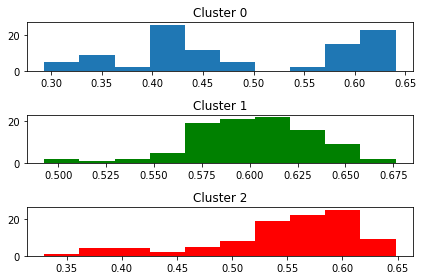

In [21]:
ax = plt.subplot(311)
ax.set_title("Cluster 0")
plt.hist(res['cluster0'], color=None)
ax = plt.subplot(312) # creates 2nd subplot with yellow background
ax.set_title("Cluster 1")
plt.hist(res['cluster1'], color='g')
ax = plt.subplot(313) # creates 2nd subplot with yellow background
ax.set_title("Cluster 2")
plt.hist(res['cluster2'], color='r')
plt.tight_layout()

In [ ]:
# pickle.dump( res, open( "bootstrap_results.pickle", "wb" ) )